In [98]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# COVID Dashboard

available sheets: 
['Read me', 'Country Risk Level', 'US Congressional District', 'US County Risk Level', 'US State Risk Level']
Date: 2021-12-13
Metric Types
['COVID-19 Risk Level' 'Daily new cases (7d moving avg.)'
 'Daily new cases per 100k people (7d moving avg.)' 'Rank']


SelectMultiple(description='Counties', index=(837, 2596, 1617), options=('Abbeville County, SC', 'Acadia Paris…

Output()

<IPython.core.display.Javascript object>


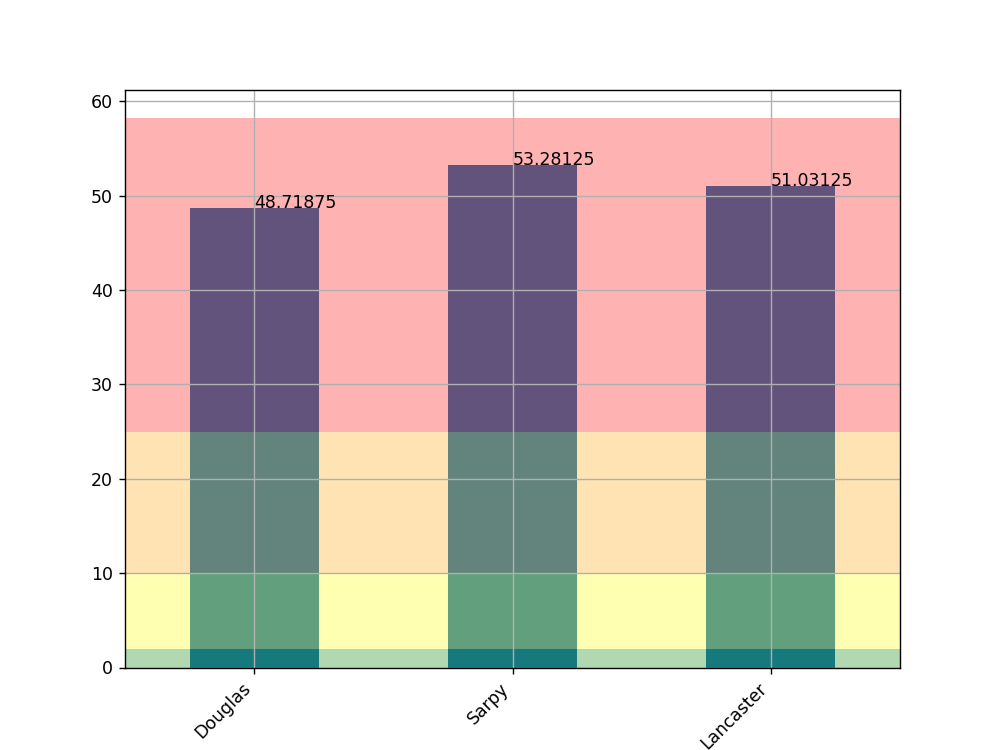

max; 53.28125


In [99]:
# Load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
#import urllib2 as urllib

#print(pd.__version__)


def get_county_norm_new_cases(county_df, name, num_days):
    #print(num_days)
    num_days_index = -num_days
    norm_cases_list = pd.Series(county_df.iloc[2,num_days_index:], name=name)
    norm_cases_df = pd.DataFrame(norm_cases_list.astype(np.float16))
    #print(type(norm_cases_list))
    #print(county_df.iloc[2,-2:-0])
    #print(county_df.iat[2, -1])
    #print("raw df: " +name)
    #print(county_df)

    return norm_cases_df

def get_county_new_cases_rank(county_df, name):
    new_cases_rank_list = pd.Series(county_df.iloc[3,-90:], name=name)
    new_cases_rank_df = pd.DataFrame(new_cases_rank_list.astype(np.float16))
    #print(type(new_cases_rank_df))
    #print(new_cases_rank_df)

    return new_cases_rank_df

# get list of series by using selected counties 
#def get_county_list(counties):
    
# get latest county values
current_county_values = dict()
counties_norm_cases = pd.Series(float)

# gets time series and latest value data from county DataFrame for a list of counties
# latest values are put in global current_county_values
# time series data is put in global counties_norm_cases
def get_latest_county_values(counties_list):
    #current_county_values
    global current_county_values
    current_county_values.clear()
    global counties_norm_cases
    series_list = list()
    
    for county in counties_list:
        county_series = county_df.loc[county_df['County'] == county]
        series_list.append(county_series)
        county_value = county_series.iat[2, -1]
        
        current_county_values[county] = county_value;
        print(county +" : " +str(county_value))
    
    
    counties_norm_cases = pd.concat(series_list)
    
#df = pd.read_csv('Risk Levels County Data.csv', parse_dates=True)

xlsx = pd.ExcelFile('../input/Risk Levels Downloadable Data.xlsx')
print('available sheets: ')
print(xlsx.sheet_names)
county_df = pd.read_excel(xlsx, "US County Risk Level")

print("Date: " +county_df.columns[-1]);
#
#print(county_df.head)
#print(county_df.dtypes)
#print(list(county_df))

# Get county list
#print("Get County List")
county_list = county_df['County'].unique()

#unique metric values
print("Metric Types")
print(county_df['Metric'].unique())

#print("Douglas Rows")

# Multiple Select object to select counties to plot
output0 = widgets.Output()
county_select = widgets.SelectMultiple(
    options=county_list.tolist(),
    name='US Counties',
    value=['Douglas County, NE', 'Sarpy County, NE', 'Lancaster County, NE'],
    rows=10,
    description='Counties',
    disabled=False
)
display(county_select, output0)

def on_value_change(change):
    with output0:
        print("Selected Counties")
        print(county_select.value)
        print(change)

# Graph configuration
plt.rcParams['figure.figsize'] = [8, 6]

# extract individual county data
douglas = county_df.loc[county_df['County'] == 'Douglas County, NE']
sarpy = county_df.loc[county_df['County'] == 'Sarpy County, NE']
lancaster = county_df.loc[county_df['County'] == 'Lancaster County, NE']


#print("iloc test: ")
#tmp_df = county_df.iloc[3350, :-1]
#print(tmp_df)

#county data offsets
# 0 - risk level color
# 1 - daily ave new cases
# 2 - daily norm ave new cases
# 3 - rank

#print(douglas)

#Current new 7 day ave new cases/100k
douglas_current = douglas.iat[2, -1]
sarpy_current = sarpy.iat[2, -1]
lancaster_current = lancaster.iat[2, -1]
cases = {"Douglas" : douglas_current, "Sarpy" : sarpy_current, "Lancaster" : lancaster_current}
current_new_cases = pd.Series(cases, 
                              dtype='float16')
#print("Current Cases - Douglas: " +douglas_current +" Sarpy: " +sarpy_current +" Lancaster: " +lancaster_current)
#print("current new cases: ")
#print(current_new_cases)

%matplotlib notebook

# create axes for plots
current_cases_graph, current_values_axes = plt.subplots()

def plot_current_case_values():
    global current_new_cases
    #global current_values_axes

    cases_set_max = max(current_new_cases) #douglas_current, sarpy_current, lancaster_current)
    print("max; " +str(cases_set_max))

    #current_values_axes = current_new_cases.plot(kind="bar", ax=current_values_axes)
    current_values_axes = current_new_cases.plot(kind="bar")
    plt.xticks(rotation=45, ha='right')

    # show values on bar graph
    for index, value in enumerate(current_new_cases):
        current_values_axes.text(index, value,
             str(value))
    #print(value)

    current_values_axes.grid()

    # add color bands for severity 
    current_values_axes.axhspan(0, 2, facecolor='green', alpha=0.3)
    current_values_axes.axhspan(2, 10, facecolor='yellow', alpha=0.3)
    current_values_axes.axhspan(10, 25, facecolor='orange', alpha=0.3)
    current_values_axes.axhspan(25, float(cases_set_max)+5, facecolor='red', alpha=0.3)
    
    plt.show()
    
plot_current_case_values()

#print('Douglas Ave New Cases /100k = ' +douglas.iat[2, -1])
#print('Douglas Rank = ' +douglas.iat[3, -1])
#print('Douglas Ave/100k past 90 days')

# Extract and plot county new cases rank
douglas_rank_series = get_county_new_cases_rank(douglas, "Douglas")
sarpy_rank_series = get_county_new_cases_rank(sarpy, "Sarpy")
lancaster_rank_series = get_county_new_cases_rank(lancaster, "Lancaster")
counties_cases_rank = pd.concat(
    [douglas_rank_series, sarpy_rank_series, lancaster_rank_series], axis=1)
#print(counties_cases_rank.shape);
#counties_cases_rank.plot()

plt.show()




## County Average Daily New Cases / 100k

<IPython.core.display.Javascript object>


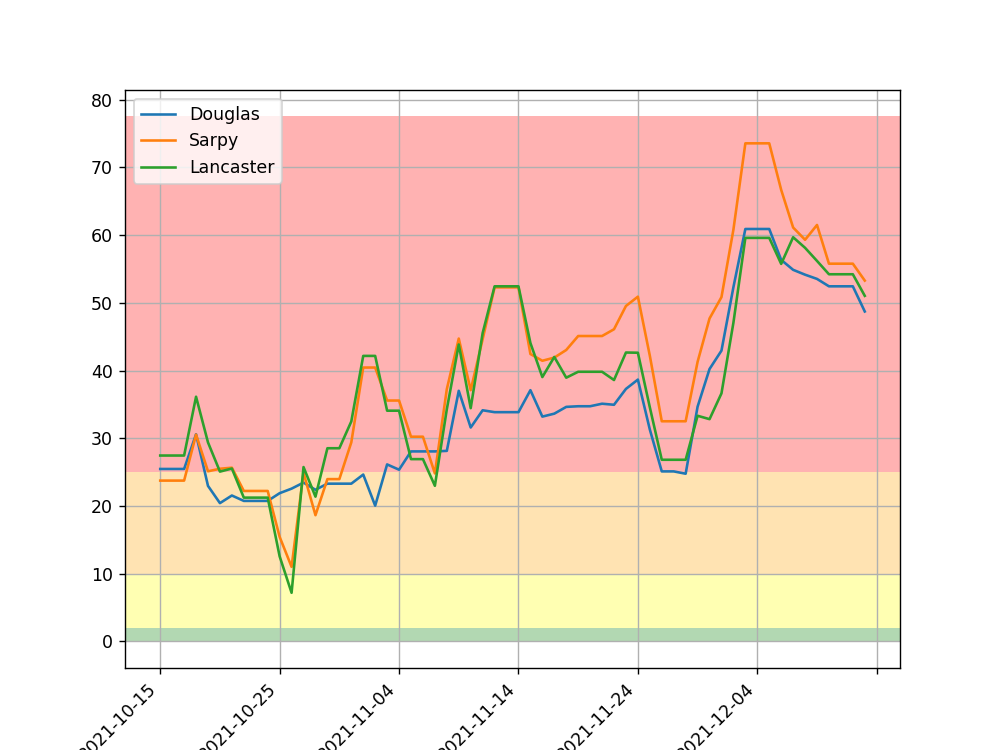

IntSlider(value=60, description='Days to Plot', max=257, min=30)

Output()

Button(description='Plot', style=ButtonStyle())

Output()

Douglas County, NE : 48.73
Sarpy County, NE : 53.27
Lancaster County, NE : 51.04
ave_cases_graph: 
<class 'matplotlib.figure.Figure'>


In [100]:
# Plot 7 day ave daily cases /100k


output = widgets.Output()

# set days to plot with IntSlider
ave_cases_graph, ave_cases_axes = plt.subplots()

#plt.ion()
plot_days= 60
max_days = len(county_df.columns) - 2
plt_range = widgets.IntSlider(description = 'Days to Plot', value = plot_days, min = 30, max = max_days);

display(plt_range, output)

def on_value_change(change):
    with output:
        global plot_days
        plot_days = change['new']
        #print(plot_days)

plt_range.observe(on_value_change, names='value')

# add plot button
output2 = widgets.Output()
plot_button = widgets.Button(description='Plot')
display(plot_button, output2)
def on_button_clicked(b):
    with output2:
        global ave_cases_graph
        global ave_cases_axes
        #ave_cases_graph.clear()
        #plt.clf()
        
        print("Selected Counties")
        print(county_select.value)
        
        
        get_latest_county_values(county_select.value)
        
        plot_current_case_values()
        
        #[l.remove() for l in ax.lines]
        #ave_cases_axes = extract_and_plot_time_series()
        #ave_cases_axes.redraw_in_frame()
        print("Button clicked: " +str(plot_days))

plot_button.on_click(on_button_clicked)

# extract and plot daily ave new cases / 100k
def extract_and_plot_time_series():
    global ave_cases_graph
    global ave_cases_axes
    #global counties_norm_cases
    
    # need to move thes series extractions to get_latest_county_values()
    douglas_series = get_county_norm_new_cases(douglas, "Douglas", plot_days)
    sarpy_series = get_county_norm_new_cases(sarpy, "Sarpy", plot_days)
    lancaster_series = get_county_norm_new_cases(lancaster, "Lancaster", plot_days)
    counties_norm_cases = pd.concat(
               [douglas_series, sarpy_series, lancaster_series], axis=1)

    max_value = counties_norm_cases.max().max()
    #print("Max value: ")
    #print(max_value)
    #print(counties_norm_cases.shape);
    #print(normCasesList.dtypes);
    #print("combined structure: " +counties_norm_cases.shape);
    ave_cases_axes = counties_norm_cases.plot(ax=ave_cases_axes)
    #counties_norm_cases.plot()
    plt.xticks(rotation=45, ha='right')
    plt.axhspan(0, 2, facecolor='green', alpha=0.3)
    plt.axhspan(2, 10, facecolor='yellow', alpha=0.3)
    plt.axhspan(10, 25, facecolor='orange', alpha=0.3)
    plt.axhspan(25, max_value+4, facecolor='red', alpha=0.3)
    plt.grid()
    #plt.show()
    print("ave_cases_graph: ")
    print(type(ave_cases_graph))

    #counties_norm_cases.style

get_latest_county_values(county_select.value)
    
ave_cases_axes = extract_and_plot_time_series()

In [101]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cd  %clear  %cls  %colors  %conda  %config  %connect_info  %copy  %ddir  %debug  %dhist  %dirs  %doctest_mode  %echo  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %macro  %magic  %matplotlib  %mkdir  %more  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %ren  %rep  %rerun  %reset  %reset_selective  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%cmd  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python 